# Weekend Movie Trip

Dalton Hahn (2762306)

## MovieLens Datasets

MovieLens Latest-Small Dataset
http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statistics import mean, stdev

## Read in the Data

In [2]:
df_links = pd.read_csv("../data/external/links.csv")
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
df_movies = pd.read_csv("../data/external/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings = pd.read_csv("../data/external/ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df_tags = pd.read_csv("../data/external/tags.csv")
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## TO-DO List
1. Separate movie title into title and a new column for year (df_movies)
2. Separate movie genres into actual list instead of weird text with bars (19 unique genres - 18 + no genre) (df_movies)
3. Timestamp may not be super relevant (may drop column)
4. Correlate columns that are similar/the same, create one dataframe with all important features
5. Links table almost completely useless, just correlates movies IDs to IMDB IDs and TheMovieDB IDs

## Data Processing

In [6]:
# 1. Separate movie title into title and year

df_movies['Year'] = df_movies.title.str.extract(pat='\((\d+)\)')
df_movies.head()

,movieId,title,genres,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [7]:
one_hot = df_movies.genres.str.get_dummies()
df_movies = df_movies.join(one_hot)
df_movies.head()

,movieId,title,genres,Year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# 2. Separate genres into a true list of genres

genres_full = []

for row in df_movies.iterrows():
    genre_list = row[1]["genres"].split("|")
    genres_full.append(genre_list)
    
df_movies.insert(len(df_movies.columns), 'Genres', genres_full, True)

# Kept all data, can safely drop the original genres column
df_movies = df_movies.drop(axis=1, columns='genres')
df_movies.head()

,movieId,title,Year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Genres
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,[Comedy]


In [9]:
genre_lookup = {"Action": 1,
               "Adventure": 2,
               "Animation": 3,
               "Children": 4,
               "Comedy": 5,
               "Crime": 6,
               "Documentary": 7,
               "Drama": 8,
               "Fantasy": 9,
               "Film-Noir": 10,
               "Horror": 11,
               "Musical": 12,
               "Mystery": 13,
               "Romance": 14,
               "Sci-Fi": 15,
               "Thriller": 16,
               "War": 17,
               "Western": 18,
               "IMAX": 19,
               "(no genres listed)": 20
             }

genre_codes = []
movie_genre = []

for row in df_movies.iterrows():
    for genre in row[1]['Genres']:
        movie_genre.append(genre_lookup[genre])
    genre_codes.append(movie_genre)
    movie_genre = []
    
    
numeric_genres = pd.Series(genre_codes)
df_movies.insert(len(df_movies.columns), 'GenreCodes', numeric_genres, True)

df_movies.head()

,movieId,title,Year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Genres,GenreCodes
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,"[Adventure, Animation, Children, Comedy, Fantasy]","[2, 3, 4, 5, 9]"
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,"[Adventure, Children, Fantasy]","[2, 4, 9]"
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,"[Comedy, Romance]","[5, 14]"
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,"[Comedy, Drama, Romance]","[5, 8, 14]"
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,[Comedy],[5]


In [10]:
# 3. Timestamp doesn't seem to be a relevant column, dropping

df_tags = df_tags.drop(axis=1, columns='timestamp')
df_tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [11]:
# 3. Timestamp doesn't seem to be a relevant column, dropping

df_ratings = df_ratings.drop(axis=1, columns='timestamp')
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Finding the distribution within genre

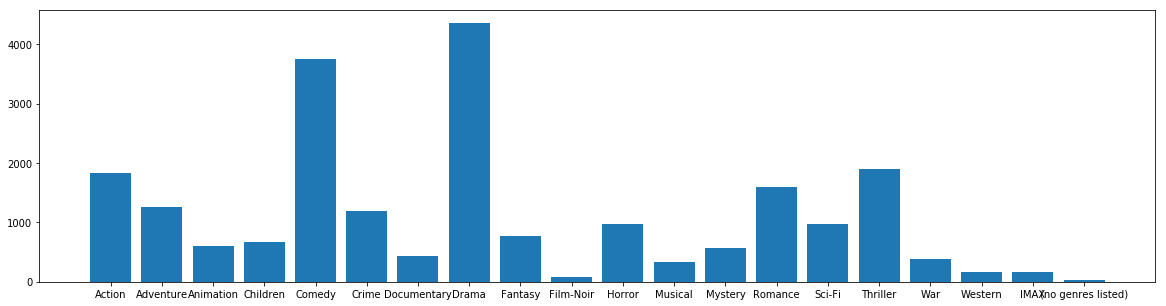

In [12]:
# CORRECTION FROM DOCUMENTATION - No "Children's" genre, actually "Children"
# CORRECTION FROM DOCUMENTATION - Unaccounted genre: IMAX

genre_dict = { "Action": 0,
               "Adventure": 0,
               "Animation": 0,
               "Children": 0,
               "Comedy": 0,
               "Crime": 0,
               "Documentary": 0,
               "Drama": 0,
               "Fantasy": 0,
               "Film-Noir": 0,
               "Horror": 0,
               "Musical": 0,
               "Mystery": 0,
               "Romance": 0,
               "Sci-Fi": 0,
               "Thriller": 0,
               "War": 0,
               "Western": 0,
               "IMAX": 0,
               "(no genres listed)": 0
             }

for row in df_movies.iterrows():
    for genre in row[1]["Genres"]:
        genre_dict[genre] = genre_dict[genre] + 1
        
#for genre, count in genre_dict.items(): 
#    print(genre, ":", count) 

plt.figure(figsize=(20,5))
plt.bar(range(len(genre_dict)), list(genre_dict.values()), align='center')
plt.xticks(range(len(genre_dict)), list(genre_dict.keys()))
plt.show()

## NOTE: By removing the year portion of the df_movies dataframe originally, I created an issue with dictionaries because there are some movie remakes that create an issue.  Will incorporate the year back into the title as well, but keep the year column separate still.

In [13]:
print(len(df_movies['title'].unique()))
print(len(df_movies['title']))

9737
9742


### Even when trying to keep movie title unique according to title+year, still having duplicate values.  Will remove these rows and continue on.

In [14]:
print(df_movies.shape)
df_movies = df_movies.drop_duplicates(subset="title")
print(df_movies.shape)

(9742, 25)
(9737, 25)


In [15]:

# Find average rating for each movie and create column

movie_rates = list()

for movie in df_movies.iterrows(): # movieId, Year, Title, Genres
    rel_ratings = df_ratings[df_ratings.movieId == movie[1]['movieId']]
    if len(rel_ratings['rating']) == 0:
        movie_rates.append(0)
    else:
        movie_rates.append(mean(rel_ratings['rating']))

    
#numeric_genres = pd.Series(genre_codes)
df_movies.insert(len(df_movies.columns), 'AvRate', movie_rates, True)

## Dealing with tags being more of a headache than it's worth for the dataset, going to proceed with clustering based on year and genre list, but have tags in their string form

In [16]:
df_movies.head()

,movieId,title,Year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Genres,GenreCodes,AvRate
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,"[Adventure, Animation, Children, Comedy, Fantasy]","[2, 3, 4, 5, 9]",3.920930
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,"[Adventure, Children, Fantasy]","[2, 4, 9]",3.431818
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,"[Comedy, Romance]","[5, 14]",3.259615
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,"[Comedy, Drama, Romance]","[5, 8, 14]",2.357143
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,[Comedy],[5],3.071429


In [17]:
df_movies.to_csv("../data/processed/movies_processed.csv")